In [1]:
!nvidia-smi

Sun Jan 22 10:50:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')
!ls
%cd gdrive/My\ Drive/MalMem/
!ls

Mounted at /content/gdrive
gdrive	sample_data
/content/gdrive/My Drive/MalMem
 adasyn_tl_xgboost_balance.ipynb
 adasyn_tl_xgboost_balance_noRUS.ipynb
 adasyn_tl_xgboost_imbalanced.ipynb
 clf_readcsv.py
 CNN_MalMem_balance
 CNN_MalMem_imbalance
 createCNN_Balanced.ipynb
 createCNN_Balanced_noRUS.ipynb（副本）
 createCNN_Imbalanced.ipynb
'Dynamic Malware Analysis with Feature Engineering and Feature Learning.pdf'
 ensemble_major_imb.ipynb
 ensemble_major.ipynb
 evaluate_auc_3Algorithm_micro.ipynb
 Evaluate_PR_3Algorithms.ipynb
 Evaluate_PR_CNN_imb.ipynb
 Evaluate_PR_CNN.ipynb
 Evaluate_PR_Voting_imb.ipynb
 Evaluate_PR_Voting.ipynb
 evaluate_PR_xgboost_imb.ipynb
 evaluate_PR_xgboost.ipynb
 evaluation_MM.xlsx
 logs
 MalMem_Test_x.csv
 MalMem_Test_y.csv
 MalMem_Train_x.csv
 MalMem_Train_y.csv
 MalMem_x.csv
 MalMem_y.csv
'Malware Memory Analysis _ Datasets _ Canadian Institute for Cybersecurity _ UNB.mhtml'
 myXgb_adasyn_MalMem_imb.json
 myXgb_adasyn_MalMem.json
 Obfuscated-MalMem2022.csv
 Obfus

In [3]:
pip install --upgrade xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 6.8 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [4]:
# -*- coding: utf-8 -*-
"""
Created on Fri Aug  5 11:26:50 2022

@author: Administrator
"""
# -*- coding: utf-8 -*-
"""
Created on Wed Jun  8 10:12:36 2022
Ton_IoT dataset
using ADASYN and tomek link, and xgboost
with 20% dataset
balanced data model on test data
@author: Administrator
"""

# from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss, classification_report, \
    plot_confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import accuracy_score
import sys
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import xgboost as xgb
import multiprocessing
import joblib


#traing dataset
# train_x = pd.read_csv('KDDTrain_x_20.csv',header=None, nrows=1000)
# train_Y = pd.read_csv('KDDTrain_y_20.csv',header=None, nrows=1000)

train_x = pd.read_csv('MalMem_Train_x.csv',header=None)
train_Y = pd.read_csv('MalMem_Train_y.csv',header=None)
test_x = pd.read_csv('MalMem_Test_x.csv',header=None)
test_Y = pd.read_csv('MalMem_Test_y.csv',header=None)

#split dataset for train and test
#train_x, test_x, train_Y, test_Y = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

# # train_Y[0]=list(train_Y[0].map({'normal':0, 'dos':1, 'ddos':2, 'injection':3, 'xss':4, \
#                                 'password':5, 'scanning':6, 'mitm':7}))
# test_Y[0]=list(train_Y[0].map({'normal':0, 'dos':1, 'ddos':2, 'injection':3, 'xss':4, \
#                                 'password':5, 'scanning':6, 'mitm':7}))

#use few dataset to test 
print("train_x", train_x.head())
print("train_y", train_Y.head())
print("test_x", test_x.head())
print("test_y", test_Y.head())
print(train_x.info())
print(train_Y.info())
print(test_x.info())
print(test_Y.info())

train_Y = train_Y.values.ravel()
test_Y  = test_Y.values.ravel()    
    
# print('train dataset shape %s' % train_Y.value.count())
# print('test dataset shape %s' % test_Y.value.count())

print('train dataset shape %s' % Counter(train_Y))
print('test dataset shape %s' % Counter(test_Y))
# sys.exit(0)

x_res = train_x
Y_res = train_Y

# #only smote
# from imblearn.over_sampling import SMOTE
# sm = SMOTE (sampling_strategy='auto', random_state=0)
# # train_x_sm, train_Y_sm = sm.fit_resample(train_x, train_Y)
# train_x_sm, train_Y_sm = sm.fit_resample(train_x, train_Y)
# print('smote dataset shape %s' % Counter(train_Y_sm))

# *******try using ADASYN on test dataset to make balance
# only 
# from imblearn.over_sampling import ADASYN
# ad = ADASYN (sampling_strategy='not majority', random_state=0)  #not majority
# train_x_sm, train_Y_sm = sm.fit_resample(train_x, train_Y)
# train_x_ad, train_Y_ad = ad.fit_resample(train_x, train_Y)
# print('adasyn dataset shape %s' % Counter(train_Y_ad))


#Tomek Links
# from imblearn.under_sampling import TomekLinks
#sampling_strategy = "all"
#tl = TomekLinks(sampling_strategy=sampling_strategy)
# x_res, Y_res = tl.fit_resample(train_x_sm, train_Y_sm)
#x_res, Y_res = tl.fit_resample(train_x_ad, train_Y_ad)
#print('Tomek Links dataset shape %s' % Counter(Y_res))

#***xgboost clf
#xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)
#xgb_model = xgb.XGBClassifier(n_jobs=1).fit(x_res, Y_res)
#kf = KFold(n_splits=2, shuffle=True, random_state=rng)
# xgb_model = xgb.XGBClassifier(objective='multi:softmax')

xgb_model = xgb.XGBClassifier()
# clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
#                                y'n_estimators': [50, 100, 200]}, verbose=1,
#                                n_jobs=2)
# param_grid = [
#     {'max_depth': [2, 4, 6], 'n_estimators': [50, 100, 200]}, 
#     {'objective': ['multi:softmax'], 'verbose': [1], 'n_jobs':[-1]},
#     ]
    
param_grid = [
    {'max_depth': [6], 'n_estimators': [200]}, 
    {'objective': ['multi:softprob'], 'num_class': [4], 'verbose': [1], 'n_jobs':[-1]},
    ]
    

# clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
#                                'n_estimators': [50, 100, 200]}, verbose=1,
#                                 n_jobs=-1)
# clf = GridSearchCV(xgb_model, param_grid, cv=2)
clf = GridSearchCV(xgb_model, param_grid, cv=5)

clf.fit(x_res, Y_res)

# save xgboost model
clf.best_estimator_.save_model('myXgb_adasyn_MalMem_imb.json')

print(clf.best_score_)
print(clf.best_params_)

#evaluation with no sampling on test data
#pred_y = xgb_model.predict(x_test)
pred_y = clf.predict(test_x)
results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)
target_names = ['Benign 0', 'Spyware 1', 'Ransomware 2', 'Trojan 3']

print("test result: \n" , results)
print("test error:", error)
# print("validation:", accuracy_score(test_Y, pred_y))
print("test validation:", accuracy_score(test_Y, pred_y))
print(classification_report(test_Y, pred_y, target_names=target_names))


train_x          0         1         2         3         4         5         6   \
0 -0.414521  0.107713 -0.408853 -0.270007 -0.784783 -0.681461 -0.366478   
1 -0.068333  0.484116 -1.182609 -0.407512 -0.818138 -1.066260 -0.406751   
2 -0.241427  0.484116 -0.923460 -0.342490 -0.748395 -0.802478 -0.388464   
3 -1.626181 -0.645094 -0.529937 -0.553809 -1.927970 -1.217187 -0.887763   
4  0.104762  0.484116 -1.114600 -0.393448 -0.611940 -0.940144 -0.351684   

         7         8         9   ...        40        41        42        43  \
0 -0.220915 -0.075494 -0.755363  ...  1.012450  0.194377 -0.518261 -0.204202   
1 -0.326264 -0.069958 -0.841029  ...  0.273750  0.194377 -0.518261 -0.204202   
2 -0.276448 -0.073746 -0.805025  ...  0.045105  0.194377 -0.518261 -0.204202   
3 -0.438350 -0.099967 -2.042836  ... -0.511119 -4.849775 -1.401328 -0.706445   
4 -0.315489 -0.067045 -0.742948  ... -0.404823  0.194377 -0.518261 -0.204202   

         44        45        46        47        48        4

result: 
 [[8749    1    0    0]
 [   3 2426  293  307]
 [   0  386 2110  426]
 [   0  279  498 2101]]
error: 0.12475112349963025
validation: 0.8752488765003698
ROC AUC Score: 0.9716638622520852
              precision    recall  f1-score   support

    Benign 0       1.00      1.00      1.00      8750
   Spyware 1       0.78      0.80      0.79      3029
Ransomware 2       0.73      0.72      0.72      2922
    Trojan 3       0.74      0.73      0.74      2878

    accuracy                           0.88     17579
   macro avg       0.81      0.81      0.81     17579
weighted avg       0.88      0.88      0.88     17579

                    pre       rec       spe        f1       geo       iba       sup

    Benign 0     0.9997    0.9999    0.9997    0.9998    0.9998    0.9996      8750
   Spyware 1     0.7846    0.8009    0.9542    0.7927    0.8742    0.7525      3029
Ransomware 2     0.7273    0.7221    0.9460    0.7247    0.8265    0.6678      2922
    Trojan 3     0.7414    0.7300

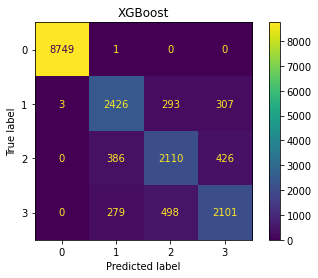

y: [[0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 ...
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
n_classes: 4


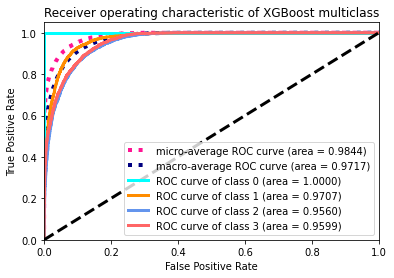

One-vs-One ROC AUC scores:
0.952938 (macro),
0.968551 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.971664 (macro),
0.981081 (weighted by prevalence),
0.984400(micro)


In [5]:
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.metrics import confusion_matrix, zero_one_loss, classification_report, \
    plot_confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay

# load model
clf = xgb.XGBClassifier()
#my_model = joblib.load("myXgbModel.pkl")
clf.load_model("myXgb_adasyn_MalMem_imb.json")

pred_y = clf.predict(test_x)  #x_res
results = confusion_matrix(test_Y, pred_y)   #Y_res
error = zero_one_loss(test_Y, pred_y)   #Y_res
#target_names = ['benign 0', 'dos 1', 'probe 2', 'r2l 3', 'u2r 4']
print("result: \n" , results)
print("error:", error)
print("validation:", accuracy_score(test_Y, pred_y))   #Y_res
yy = clf.predict_proba(test_x)  

# yy = clf.decision_function(x_res)[:, 1]
rac = roc_auc_score(test_Y, yy, multi_class='ovr', average ='macro')  #Y_res
print("ROC AUC Score:", rac)
print(classification_report(test_Y, pred_y, target_names=target_names))   #Y_res


print(classification_report_imbalanced(test_Y, pred_y, digits=4, target_names=target_names))  
print(f"The geometric mean is {geometric_mean_score(test_Y, pred_y):.3f}") 

cm = confusion_matrix(test_Y, pred_y, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
_ = disp.ax_.set_title("XGBoost")
plt.show()
# ***plot confusion matrix
# plt.matshow(results, cmap=plt.cm.gray)
# plt.show()

# plot roc curve
y = label_binarize(test_Y, classes=[0, 1, 2, 3])  
n_classes = y.shape[1]

print("y:", y)
print("n_classes:", n_classes)

lw = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # fpr[i], tpr[i], _ = roc_curve(Y_res[:, i], y[:, i])
    # fpr[i], tpr[i], threshold = roc_curve(y[:, i], yy[:, i], pos_label=0)
    fpr[i], tpr[i], threshold = roc_curve(y[:, i], yy[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), yy.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.4f})".format(roc_auc["micro"]),  #2
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.4f})".format(roc_auc["macro"]),  #2
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "#FF6666"]) #, "green","yellow","slategray","blueviolet"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),   #2
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic of XGBoost multiclass")
plt.legend(loc="lower right")
plt.show()


# compute roc_auc_score
# y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(test_Y, yy, multi_class="ovo", average="macro")  #Y_res
weighted_roc_auc_ovo = roc_auc_score(test_Y, yy, multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(test_Y, yy, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(test_Y, yy, multi_class="ovr", average="weighted") #Y_res
#micro_roc_auc_ovr = roc_auc_score(test_Y, yy, multi_class="ovr", average="micro")   #leon

print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence),\n{:.6f}"   #leon
    "(micro)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr, roc_auc["micro"])  #leon

)